### Solve linear equations using Quantum.

### Framework impl

In [108]:
# !pip install git+https://github.com/anedumla/quantum_linear_solvers


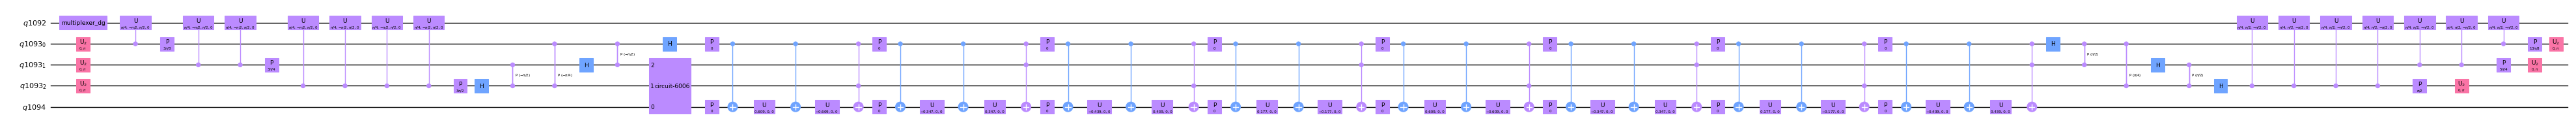

In [109]:
import numpy as np
from linear_solvers import NumPyLinearSolver, HHL
matrix = np.array([[1,-1/3], [-1/3,1]])
vector = np.array([0,1])
naive_hhl_solution = HHL().solve(matrix, vector)
naive_hhl_solution.state.decompose().decompose().decompose().draw(fold=1000, output="mpl", scale=0.5)


In [110]:
from linear_solvers.matrices.tridiagonal_toeplitz import TridiagonalToeplitz
tridi_matrix = TridiagonalToeplitz(1, 1, -1 / 3)
tridi_solution = HHL().solve(tridi_matrix, vector)
print(tridi_solution.state)


         ┌──────────────┐┌──────┐        ┌─────────┐
  q1123: ┤ circuit-6014 ├┤3     ├────────┤3        ├
         └──────────────┘│      │┌──────┐│         │
q1124_0: ────────────────┤0     ├┤2     ├┤0        ├
                         │  QPE ││      ││  QPE_dg │
q1124_1: ────────────────┤1     ├┤1     ├┤1        ├
                         │      ││  1/x ││         │
q1124_2: ────────────────┤2     ├┤0     ├┤2        ├
                         └──────┘│      │└─────────┘
  q1125: ────────────────────────┤3     ├───────────
                                 └──────┘           


In [111]:
print('naive Euclidean norm:', naive_hhl_solution.euclidean_norm)
print('tridiagonal Euclidean norm:', tridi_solution.euclidean_norm)
from qiskit.quantum_info import Statevector

naive_sv = Statevector(naive_hhl_solution.state).data

# Extract vector components; 10000(bin) == 16 & 10001(bin) == 17
naive_full_vector = np.array([naive_sv[16], naive_sv[17] ])

print('naive raw solution vector:', naive_full_vector)

naive Euclidean norm: 1.1858541225631383
tridiagonal Euclidean norm: 1.1858541225631385
naive raw solution vector: [0.25+2.96764898e-17j 0.75+2.95198510e-16j]


In [112]:
from qiskit.quantum_info import Statevector

naive_sv = Statevector(naive_hhl_solution.state).data
tridi_sv = Statevector(tridi_solution.state).data

# Extract vector components; 10000(bin) == 16 & 10001(bin) == 17
naive_full_vector = np.array([naive_sv[16], naive_sv[17] ])
tridi_full_vector = np.array([tridi_sv[16], tridi_sv[17] ])

print('naive raw solution vector:', naive_full_vector)
print('tridi raw solution vector:', tridi_full_vector)

naive raw solution vector: [0.25+2.96764898e-17j 0.75+2.95198510e-16j]
tridi raw solution vector: [0.25-2.44713629e-16j 0.75-6.31716888e-17j]


In [113]:
def get_solution_vector(solution):
    """Extracts and normalizes simulated state vector
    from LinearSolverResult."""
    solution_vector = Statevector(solution.state).data[16:18].real
    norm = solution.euclidean_norm
    return norm * solution_vector / np.linalg.norm(solution_vector)

print('full naive solution vector:', get_solution_vector(naive_hhl_solution))
print('full tridi solution vector:', get_solution_vector(tridi_solution))


full naive solution vector: [0.375 1.125]
full tridi solution vector: [0.375 1.125]


In [114]:
ans = get_solution_vector(tridi_solution)
np.dot(matrix, ans)

array([-3.33066907e-16,  1.00000000e+00])

### Implementation

In [115]:
from qiskit import *
from  qiskit.extensions import *
import numpy as np
from qiskit.circuit.library import *
from qiskit.visualization import *
from qiskit.quantum_info import Statevector
from qiskit.circuit.library.standard_gates import RYGate

A = [[1,-1/3], 
     [-1/3,1]]

# A = [[0,0,1,-1/3],
#      [0,0,-1/3,1],
#      [1,-1/3,0,0],
#      [-1/3,1,0,0]]

B = [0,1]

BNorm = B / np.linalg.norm(B)

NL = 2
NB = 1
NA = 1
breg = QuantumRegister(NB, name="B")
lreg = QuantumRegister(NL)
creg = ClassicalRegister(2)
areg = QuantumRegister(NA, name="anc")

QC = QuantumCircuit(areg, creg, lreg, breg)
QC.initialize(BNorm, breg)
QC.barrier()
S = Statevector(QC)
S.draw(output="Latex")

<IPython.core.display.Latex object>

In [116]:

U = HamiltonianGate(A, time=3*np.pi/2)

for i in range(2):
    QC.h(i+1)

i = NL
j = NL
while j > 0:
    print (i,j)
    g = QuantumCircuit(1,name="H^"+str(i))

    # for _ in range(i):
    g.hamiltonian(A, (2**(i-1))*3*np.pi/8, [0])
        # g.append(U, [0])
    
    g = g.to_gate().control(1)

    QC.append(g, [3-j, 3])
    i //= 2
    j -= 1

    
QC.barrier()

R = list(range(1,NL+1))[::-1]+list([NL+1])
QC.append(QFT(NL, inverse=True, do_swaps=False, name="QFT"), [2,1])  
QC.barrier()
QC.swap(1,2)
QC.barrier()



2 2
1 1


In [117]:
S = Statevector(QC)
S.draw(output="Latex")


<IPython.core.display.Latex object>

In [118]:
C = 1
U = RYGate(2*np.arcsin(C/1)).control(1)
# QC.x(2)
QC.append(U, [1,0])
# QC.x(2)

U = RYGate(2*np.arcsin(C/2)).control(1)
# QC.x(1)
QC.append(U, [2,0])
# QC.x(1)
QC.measure(0,0)
QC.barrier()

QC.swap(1,2)
QC.barrier()
QC.append(QFT(NL, do_swaps=False), list(range(1,NL+1))[::-1])
i = 1
j = 1
while i < NL+1:
    # U = HamiltonianGate(A, time=-3*np.pi/8)
    g = QuantumCircuit(1,name="H^"+str(i))

    # for _ in range(i):
    g.hamiltonian(A, -(2**(i-1))*3*np.pi/4, [0])
        # g.append(U, [0])
    
    g = g.to_gate().control(1)

    QC.append(g, [3-j, NA+NL])
    i *= 2
    j += 1

for i in range(2):
    QC.h(i+1)
    
QC.barrier()

# S = Statevector(QC)
# S.draw(output="Latex")

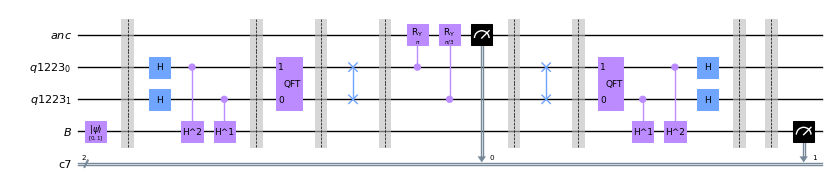

In [119]:
QC.barrier()
QC.measure(3,1)
# QC = QC.decompose()

QC.draw(output="mpl", scale=0.5, fold=1200)

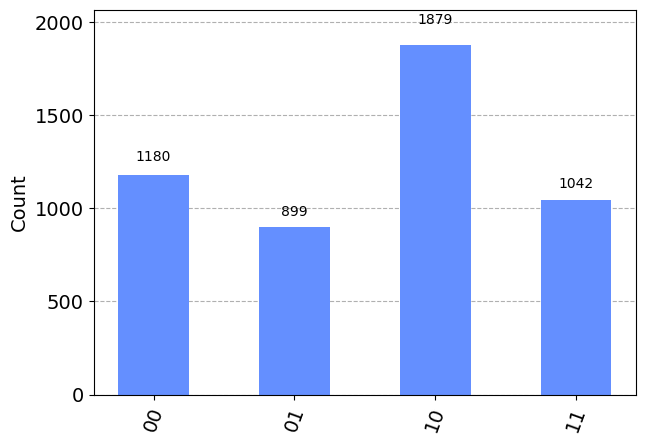

In [120]:
import qiskit
# Execute the circuit using the simulator
simulator = qiskit.Aer.get_backend('aer_simulator')
job = execute(QC, backend=simulator, shots=5000)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts(QC)

# Display the results
plot_histogram(counts)

In [121]:
nshots = 1000
amp_value = {}
ans = []
# for i in range(16,32):
#     value = np.round(S[i-16], 10)
#     if value:
#         amp_value[bin(i)[3:]] = value
        
# print (amp_value)
pshots = 0
for k,v in result.get_counts().items():
    if k[-1] == '1':
        print (k,v)
        ans.append(v)
        pshots += v
ans = np.round([(i/nshots) for i in ans], 3)
# ans = np.round(sum([i**2 for i in ans]),3)
P1 = sum([i*i for i in ans])
ans = ([i*i for i in ans])
print ('----', ans[0]/ans[1])
scaling = (C/np.sqrt(P1))
ans = [i/(scaling*np.linalg.norm(ans)) for i in ans]

print (scaling,)
print (ans, )
print (np.dot(ans, A))

11 1042
01 899
---- 1.343433131114661
0.7266311729732712
[1.1039517845655917, 0.8217392879462717]
[0.83003869 0.45375536]


In [122]:
bcknd = Aer.get_backend('statevector_simulator')

job_sim = execute(QC, bcknd)
result = job_sim.result()

o_state_result = result.get_statevector(QC, decimals=3)
print(o_state_result)

Statevector([ 0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ,  0.   -0.j   ,
              0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   , -0.   +0.j   ,
              0.   +0.j   ,  0.13 +0.438j,  0.   +0.j   ,  0.679+0.442j,
              0.   +0.j   ,  0.066-0.027j,  0.   +0.j   ,  0.344-0.106j],
            dims=(2, 2, 2, 2))
